In [1]:
from matplotlib import pyplot as plt
import pymatching
import numpy as np
from copy import deepcopy
from circuit_generators import *
from sampling_functions import *
from bitpack import pack_bits, unpack_bits
from circuit_partition import *
from utilities_tf import *
from CNNModel import *
import time 
from keras.optimizers import Adam
import os
import json 
import pickle

t0 = time.time()

# Number of worker nodes
n_worker_nodes = 8

# Surface code specifications
d = 5
r = 2
kernel_size = 3

# Error probabilities
p = 0.01
before_round_data_depolarization = p
after_reset_flip_probability = p
after_clifford_depolarization = p
before_measure_flip_probability = p

use_rotated_z = True
observable_type = "ZL" if use_rotated_z else "XL"

# Bit types
binary_t = np.int8 # Could use even less if numpy allowed

# Measurement index type
idx_t = np.int8
n_all_measurements = r*(d**2-1) + d**2
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int16
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int32
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int64
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int128
if n_all_measurements > np.iinfo(idx_t).max:
  idx_t = np.int256
if n_all_measurements > np.iinfo(idx_t).max:
  raise RuntimeError("idx_t is too small.")

# Call signature for circuit_partition::group_det_bits_kxk
call_group_det_bits_kxk = lambda det_bits_dxd, data_bits_dxd=None, d=d, r=r, k=kernel_size, use_rotated_z=use_rotated_z, binary_t=binary_t, idx_t=idx_t: group_det_bits_kxk(det_bits_dxd, d, r, k, use_rotated_z, data_bits_dxd, binary_t, idx_t)

2024-06-19 15:00:06.419030: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def split_measurements(measurements, d):
  n_measurements = idx_t(measurements.shape[1])
  # Measurements on data qubits come last
  exclude_indices = np.array([-x-1 for x in range(d**2)], dtype=idx_t)
  exclude_indices = exclude_indices + n_measurements
  # Out of all measurements on data qubits, the logical qubit measurements are those on the boundary of the lattice.
  # All other equivalent X_L/Z_L operators can be found through the combination of ancilla measurements and the chosen data qubits giving us the logical qubit.
  exclude_indices_obsL = np.array([-x-1 for x in range(d*(d-1), d**2)], dtype=idx_t)
  exclude_indices_obsL = exclude_indices_obsL + n_measurements
  # From obs_bits, we want to exclude all measurements except those listed in exclude_indices_obsL
  exclude_indices_obs = np.arange(0, n_measurements, 1, dtype=idx_t)
  exclude_indices_obs = np.delete(exclude_indices_obs, exclude_indices_obsL)

  det_bits = measurements
  det_bits = np.delete(det_bits, exclude_indices, axis=1)
  obs_bits = measurements
  obs_bits = np.delete(obs_bits, exclude_indices_obs, axis=1)

  data_bits = measurements[:, exclude_indices]

  # Reverse the order of data_bits because exclude_indices starts from the last data qubit measurement, not the first
  data_bits = np.flip(data_bits, axis=1)

  return det_bits, obs_bits, data_bits

In [3]:
def get_stim_output(n_total, split):
  # this is using globals defined in the first cell!
  n_test = int(n_total*split)
  n_train = int(n_total*(1-split))
  n_samples = n_test + n_train
  decoders = ['pymatching']
  test_circuit = get_builtin_circuit(
    "surface_code:rotated_memory_"+('z' if use_rotated_z else 'x'),
    distance=d,
    rounds=r,
    before_round_data_depolarization = before_round_data_depolarization,
    after_reset_flip_probability = after_reset_flip_probability,
    after_clifford_depolarization = after_clifford_depolarization,
    before_measure_flip_probability = before_measure_flip_probability
  )

  kernel_circuit_extra_depol1 = [
    [
      f"DEPOLARIZE1({after_clifford_depolarization}) 13 25",
      f"DEPOLARIZE1({after_clifford_depolarization}) 5 13 17 19 25",
      f"#DEPOLARIZE1({after_clifford_depolarization})",
      f"DEPOLARIZE1({after_clifford_depolarization}) 12 15 19",
    ], # parity = (1, 1)
    [
      f"DEPOLARIZE1({after_clifford_depolarization}) 8 13 25",
      f"DEPOLARIZE1({after_clifford_depolarization}) 5 13 17 19 25",
      f"DEPOLARIZE1({after_clifford_depolarization}) 1 14 15",
      f"DEPOLARIZE1({after_clifford_depolarization}) 12 14 15 19",
    ], # parity = (0, 1)
    [
      f"DEPOLARIZE1({after_clifford_depolarization}) 8 25",
      f"DEPOLARIZE1({after_clifford_depolarization}) 17 25",
      f"DEPOLARIZE1({after_clifford_depolarization}) 1 14 15",
      f"DEPOLARIZE1({after_clifford_depolarization}) 14 15",
    ], # parity = (-1, 1)
    [
      f"DEPOLARIZE1({after_clifford_depolarization}) 5 13 25",
      f"DEPOLARIZE1({after_clifford_depolarization}) 5 13 17 19 25",
      f"DEPOLARIZE1({after_clifford_depolarization}) 2 3",
      f"DEPOLARIZE1({after_clifford_depolarization}) 2 12 15 19",
    ], # parity = (1, 0)
    [
      f"DEPOLARIZE1({after_clifford_depolarization}) 1 5 8 13 25",
      f"DEPOLARIZE1({after_clifford_depolarization}) 5 13 17 19 25",
      f"DEPOLARIZE1({after_clifford_depolarization}) 1 2 3 14 15",
      f"DEPOLARIZE1({after_clifford_depolarization}) 2 12 14 15 19",
    ] # parity = (0, 0)
  ]
  kernel_circuits = []
  for replace_args in kernel_circuit_extra_depol1:
    kernel_circuit_template = \
    f"""
  QUBIT_COORDS(1, 1) 1
  QUBIT_COORDS(2, 0) 2
  QUBIT_COORDS(3, 1) 3
  QUBIT_COORDS(5, 1) 5
  QUBIT_COORDS(1, 3) 8
  QUBIT_COORDS(2, 2) 9
  QUBIT_COORDS(3, 3) 10
  QUBIT_COORDS(4, 2) 11
  QUBIT_COORDS(5, 3) 12
  QUBIT_COORDS(6, 2) 13
  QUBIT_COORDS(0, 4) 14
  QUBIT_COORDS(1, 5) 15
  QUBIT_COORDS(2, 4) 16
  QUBIT_COORDS(3, 5) 17
  QUBIT_COORDS(4, 4) 18
  QUBIT_COORDS(5, 5) 19
  QUBIT_COORDS(4, 6) 25
  R 1 3 5 8 10 12 15 17 19
  X_ERROR({after_reset_flip_probability}) 1 3 5 8 10 12 15 17 19
  R 2 9 11 13 14 16 18 25
  X_ERROR({after_reset_flip_probability}) 2 9 11 13 14 16 18 25
  TICK
  DEPOLARIZE1({before_round_data_depolarization}) 1 3 5 8 10 12 15 17 19
  H 2 11 16 25
  DEPOLARIZE1({after_clifford_depolarization}) 2 11 16 25
  TICK
  CX 2 3 16 17 11 12 15 14 10 9 19 18
  DEPOLARIZE2({after_clifford_depolarization}) 2 3 16 17 11 12 15 14 10 9 19 18
  {replace_args[0]}
  TICK
  CX 2 1 16 15 11 10 8 14 3 9 12 18
  DEPOLARIZE2({after_clifford_depolarization}) 2 1 16 15 11 10 8 14 3 9 12 18
  {replace_args[1]}
  TICK
  CX 16 10 11 5 25 19 8 9 17 18 12 13
  DEPOLARIZE2({after_clifford_depolarization}) 16 10 11 5 25 19 8 9 17 18 12 13
  {replace_args[2]}
  TICK
  CX 16 8 11 3 25 17 1 9 10 18 5 13
  DEPOLARIZE2({after_clifford_depolarization}) 16 8 11 3 25 17 1 9 10 18 5 13
  {replace_args[3]}
  TICK
  H 2 11 16 25
  DEPOLARIZE1({after_clifford_depolarization}) 2 11 16 25
  TICK
  X_ERROR({before_measure_flip_probability}) 2 9 11 13 14 16 18 25
  MR 2 9 11 13 14 16 18 25
  X_ERROR({after_reset_flip_probability}) 2 9 11 13 14 16 18 25
  DETECTOR(0, 4, 0) rec[-4]
  DETECTOR(2, 2, 0) rec[-7]
  DETECTOR(4, 4, 0) rec[-2]
  DETECTOR(6, 2, 0) rec[-5]
  REPEAT {r-1} {{
    TICK
    DEPOLARIZE1({before_round_data_depolarization}) 1 3 5 8 10 12 15 17 19
    H 2 11 16 25
    DEPOLARIZE1({after_clifford_depolarization}) 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    DEPOLARIZE2({after_clifford_depolarization}) 2 3 16 17 11 12 15 14 10 9 19 18
    {replace_args[0]}
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    DEPOLARIZE2({after_clifford_depolarization}) 2 1 16 15 11 10 8 14 3 9 12 18
    {replace_args[1]}
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    DEPOLARIZE2({after_clifford_depolarization}) 16 10 11 5 25 19 8 9 17 18 12 13
    {replace_args[2]}
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    DEPOLARIZE2({after_clifford_depolarization}) 16 8 11 3 25 17 1 9 10 18 5 13
    {replace_args[3]}
    TICK
    H 2 11 16 25
    DEPOLARIZE1({after_clifford_depolarization}) 2 11 16 25
    TICK
    X_ERROR({before_measure_flip_probability}) 2 9 11 13 14 16 18 25
    MR 2 9 11 13 14 16 18 25
    X_ERROR({after_reset_flip_probability}) 2 9 11 13 14 16 18 25
    SHIFT_COORDS(0, 0, 1)
    DETECTOR(2, 0, 0) rec[-8] rec[-16]
    DETECTOR(2, 2, 0) rec[-7] rec[-15]
    DETECTOR(4, 2, 0) rec[-6] rec[-14]
    DETECTOR(6, 2, 0) rec[-5] rec[-13]
    DETECTOR(0, 4, 0) rec[-4] rec[-12]
    DETECTOR(2, 4, 0) rec[-3] rec[-11]
    DETECTOR(4, 4, 0) rec[-2] rec[-10]
    DETECTOR(4, 6, 0) rec[-1] rec[-9]
  }}
  X_ERROR({before_measure_flip_probability}) 1 3 5 8 10 12 15 17 19
  M 1 3 5 8 10 12 15 17 19
  DETECTOR(0, 4, 1) rec[-3] rec[-6] rec[-13]
  DETECTOR(2, 2, 1) rec[-5] rec[-6] rec[-8] rec[-9] rec[-16]
  DETECTOR(4, 4, 1) rec[-1] rec[-2] rec[-4] rec[-5] rec[-11]
  DETECTOR(6, 2, 1) rec[-4] rec[-7] rec[-14]
  OBSERVABLE_INCLUDE(0) rec[-7] rec[-8] rec[-9]
    """
    kernel_circuits.append(stim.Circuit(kernel_circuit_template))


  # Sampling for the dxd circuit
  m_sampler = test_circuit.compile_sampler(seed=12345)
  converter = test_circuit.compile_m2d_converter()
  detector_error_model = test_circuit.detector_error_model(decompose_errors=True)

  measurements = m_sampler.sample(n_samples, bit_packed=False)
  det_evts, flips = converter.convert(measurements=measurements, separate_observables=True, bit_packed=False)
  measurements = measurements.astype(binary_t)
  det_evts = det_evts.astype(binary_t)
  flips = flips.astype(binary_t)

  avg_flips = np.sum(flips.reshape(-1,), dtype=np.float32)/flips.shape[0]
  print(f"Average flip rate for the full circuit: {avg_flips}")

  # next cell
  n_measurements = idx_t(measurements.shape[1])
  det_bits, obs_bits, data_bits = split_measurements(measurements, d)

  # next cell
  det_bits_kxk_all, data_bits_kxk_all, obs_bits_kxk_all, kernel_result_translation_map = call_group_det_bits_kxk(det_bits, data_bits_dxd=data_bits)
  kernel_types = get_unique_kernel_types(kernel_size, d)
  n_kernels = det_bits_kxk_all.shape[0]

  # next cell
  kernel_result_translation_map_f = kernel_result_translation_map[:,:,1:]
  kernel_result_translation_map_b = kernel_result_translation_map[:,:,0:-1]
  kernel_result_translation_det_evts = (kernel_result_translation_map_f!=kernel_result_translation_map_b).astype(binary_t)
  kernel_result_translation_map = np.concatenate((kernel_result_translation_map, kernel_result_translation_det_evts), axis=2)

  # next cell
  det_evts_kxk_all = []
  flips_kxk_all = []
  converters_kernel = []
  for kernel_circuit in kernel_circuits:
    converters_kernel.append(kernel_circuit.compile_m2d_converter())
  for k in range(n_kernels):
    measurements_kxk = np.concatenate((det_bits_kxk_all[k], data_bits_kxk_all[k]), axis=1).astype(np.bool_)
    ik = 0
    for i, kernel_type in enumerate(kernel_types):
      if k in kernel_type[1]:
        ik = i
        break
    det_evts_kxk, flips_kxk = converters_kernel[ik].convert(measurements=measurements_kxk, separate_observables=True, bit_packed=False)
    det_evts_kxk_all.append(det_evts_kxk)
    flips_kxk_all.append(flips_kxk)
  det_evts_kxk_all = np.array(det_evts_kxk_all, dtype=binary_t)
  flips_kxk_all = np.array(flips_kxk_all, dtype=binary_t)
  del converters_kernel

  # next cell
  class_bits = flips
  features_det_bits = np.swapaxes(det_bits_kxk_all, 0, 1)
  features_det_evts = np.swapaxes(det_evts_kxk_all, 0, 1)
  features_translation_map = np.swapaxes(kernel_result_translation_map, 0, 1) # Dimensions go as [sample][kernel][cycle bits + detections (n_cycles-1)]
  features_translation_map = np.reshape(features_translation_map, (features_translation_map.shape[0], -1))
  features_final_det_evts = det_evts[:, -((d**2-1)//2):]

  return {"CNN": [[features_det_bits,
                   features_det_evts,
                   features_translation_map,
                   features_final_det_evts],
                  class_bits], 
          "pymatch": [detector_error_model, det_evts, flips]}

In [4]:
def get_pymatching_result(stim_output, idxs_test):
    detector_error_model, det_evts, flips = stim_output["pymatch"]
    pymatcher = pymatching.Matching.from_detector_error_model(detector_error_model)
    flips_pred_pym = pymatcher.decode_batch(det_evts, bit_packed_predictions=False, bit_packed_shots=False).astype(binary_t).reshape(-1,1)
    flips_pred_pym = pymatcher.decode_batch(det_evts[idxs_test,:], bit_packed_predictions=False, bit_packed_shots=False).astype(binary_t).reshape(-1,1)
    pymatch_error_rate_test = np.sum(
        (flips_pred_pym!=flips[idxs_test,:]))/flips_pred_pym.shape[0]
    return pymatch_error_rate_test

In [5]:
def learning_rate_scheduler(epoch, lr):
  if epoch < 10:
    return lr
  elif epoch < 20:
    return lr * 0.9
  elif epoch < 30:
    return lr * 0.8
  else:
    return lr * 0.65

In [13]:
name = "sc-CNN-training-lr0.0005"
n_totals = np.array([10**5, 10**6, 10**7], dtype=int)
frac_test = 0.2
batch_size = 10**3  
n_epochs = 60
n_nodes = 150
lr = 0.0005

In [14]:
# save params 
params = {
  "d": d,
  "r": r,
  "kernel_size": kernel_size,
  "p": p,
  "before_round_data_depolarization": before_round_data_depolarization,
  "after_reset_flip_probability": after_reset_flip_probability,
  "after_clifford_depolarization": after_clifford_depolarization,
  "before_measure_flip_probability": before_measure_flip_probability,
  "use_rotated_z": use_rotated_z,
  "observable_type": observable_type,
  "name": name,
  "n_totals": n_totals.tolist(),
  "frac_test": frac_test,
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "n_nodes": n_nodes,
  "lr": lr,
  "history_paths": [f"{name}/model_{n_total:0.3e}.json" for n_total in n_totals]
}
os.makedirs(name, exist_ok=True)
param_filename = os.path.join(name, "setup.json")
with open(param_filename, "w") as f: json.dump(params, f)

# run stim
max_total = np.max(n_totals)
stim_output = get_stim_output(max_total, frac_test)
[[features_det_bits,
  features_det_evts,
  features_translation_map,
  features_final_det_evts], class_bits] = stim_output["CNN"]

# PyMatching error rate
pymatch_error_rate = get_pymatching_result(
  stim_output, np.arange(max_total, dtype=np.int32))
print(f"PyMatching error rate for full data set: "
      f"{100*pymatch_error_rate:0.4f}%")

histories = []
best_rounds = []
best_accuracies = []
for i_n, n_total in enumerate(n_totals):
  # train-test split
  # Make sure the data type is np.int32 below, not idx_t!
  idxs_test, idxs_train = split_data(
      np.arange(n_total, dtype=np.int32), 
      test_size=frac_test, 
      seed=12345, shuffle=False)
  
  # package stim output
  data = {}
  for label, index in zip(["test", "train"], 
                          [idxs_test, idxs_train]):
      data[label] = [features_det_bits[index], 
                      features_det_evts[index],
                      features_translation_map[index], 
                      features_final_det_evts[index] ]
  
  # train the model
  print(f"\nTraining CNN model for {n_total:0.1e} samples")
  model_dxd = FullCNNModel(
    observable_type, d, kernel_size, r,
    [n_nodes for _ in range(2)], npol=2,
    do_all_data_qubits=False, extended_kernel_output=True, 
    include_det_evts=True, include_last_kernel_dets=False, 
    include_last_dets=True, has_nonuniform_response=False, 
    use_translated_kernels=False
  )
  model_dxd.compile(optimizer=Adam(learning_rate=lr), 
                    loss='binary_crossentropy', metrics=['accuracy'])
  history = model_dxd.fit(
    x=data["train"],
    y=class_bits[idxs_train,:],
    batch_size=batch_size,
    epochs=n_epochs, 
    validation_data=(data["test"], class_bits[idxs_test,:]),
    callbacks=[
      # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
      #                                 restore_best_weights=True),
      # tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
    ]
  )
  with open(params["history_paths"][i_n], "w") as f: 
     json.dump(history.history, f)
  histories.append(history)
  
  # evaluate the model
  print(f"\nFor {n_total:0.1e} samples:")
  best_rounds.append(np.argmax(history.history['val_accuracy']))
  best_accuracies.append(history.history['val_accuracy'][best_rounds[-1]])
  print(f"Best CNN test error rate: {100*(1-best_accuracies[-1]):.4f}% "
        f"in epoch {best_rounds[-1] + 1}/{n_epochs}")
  print()
  


Average flip rate for the full circuit: 0.2298373
PyMatching error rate for full data set: 3.1560%

Training CNN model for 1.0e+05 samples
Number of unique contributions: 13
Total number of fractions: 28
Total number of phases: 62
Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 185ms/step - accuracy: 0.6686 - loss: 0.6243 - val_accuracy: 0.7687 - val_loss: 0.5264
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7728 - loss: 0.5150 - val_accuracy: 0.7687 - val_loss: 0.4927
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7727 - loss: 0.4791 - val_accuracy: 0.7780 - val_loss: 0.4622
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7840 - loss: 0.4496 - val_accuracy: 0.7821 - val_loss: 0.4426
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7846 - loss: 0.4352 - val_accuracy: 0.7788 - val_loss: 0.4278
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7819 - loss: 0.4219 - val_accuracy: 0.7780 - val_loss: 0.4161
Epoch

2024-06-19 23:33:07.931440: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1152000000 exceeds 10% of free system memory.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 132s 59ms/step - accuracy: 0.8604 - loss: 0.3077 - val_accuracy: 0.9449 - val_loss: 0.1378
Epoch 2/60
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 110s 55ms/step - accuracy: 0.9481 - loss: 0.1313 - val_accuracy: 0.9518 - val_loss: 0.1226
Epoch 3/60
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 109s 54ms/step - accuracy: 0.9535 - loss: 0.1181 - val_accuracy: 0.9560 - val_loss: 0.1128
Epoch 4/60
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 110s 54ms/step - accuracy: 0.9565 - loss: 0.1117 - val_accuracy: 0.9571 - val_loss: 0.1112
Epoch 5/60
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 110s 54ms/step - accuracy: 0.9581 - loss: 0.1077 - val_accuracy: 0.9590 - val_loss: 0.1055
Epoch 6/60
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 109s 54ms/step - accuracy: 0.9593 - loss: 0.1046 - val_accuracy: 0.9590 - val_loss: 0.1056
Epoch 7/60
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 109s 54ms/step - accuracy: 0.9601 - loss: 0.1028 - val_accuracy: 0.9601 - val_loss: 0.1028
Epoch 8/60
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 109s 54ms/step - accuracy: 0.9610 - lo

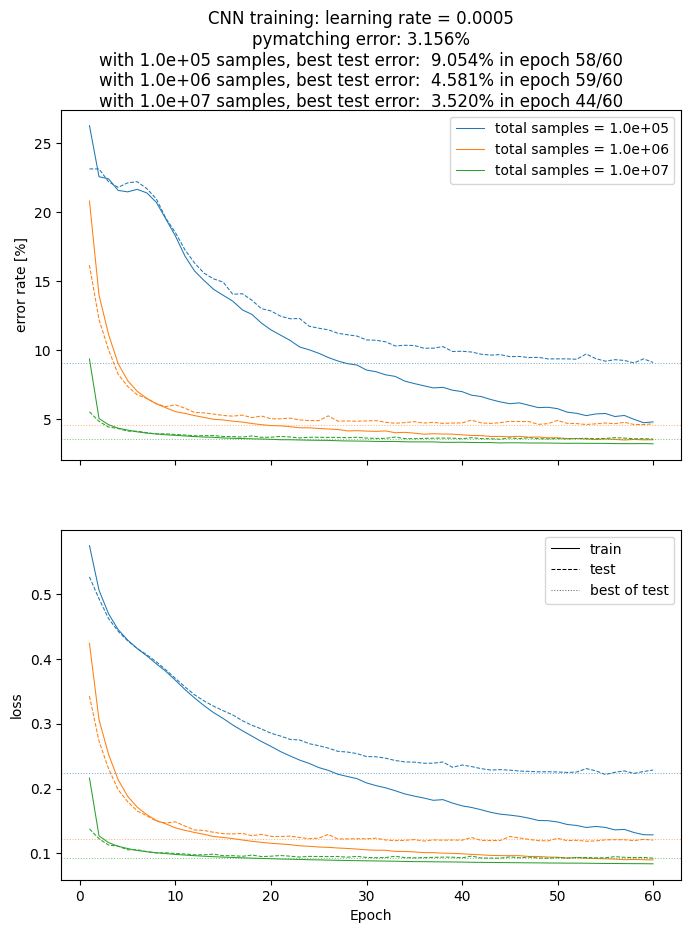

In [15]:
# plot training history 
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 10))
linewidth = 0.75
epochs = np.arange(1, n_epochs + 1)
plots = ["error rate", "loss"]
colors = []
for n_total, history, best in zip(n_totals, histories, best_rounds):
  for ax_i, plot in enumerate(plots):
    if plot == "error rate":
      train = 100*(1 - np.asarray(history.history['accuracy']))
      test = 100*(1 - np.asarray(history.history['val_accuracy']))
    else:
      train = history.history[plot]
      test = history.history[f"val_{plot}"]
    label = f'total samples = {n_total:0.1e}' if ax_i==0 else None
    line = axes[ax_i].plot(epochs, train, label=label,
                           linestyle='solid', linewidth=linewidth, marker='')
    colors.append(line[0].get_color())
    axes[ax_i].plot(epochs, test, linestyle='dashed', 
                    linewidth=linewidth, marker='', color=colors[-1])
    axes[ax_i].axhline(test[best], linestyle='dotted', alpha=0.6,
                       linewidth=linewidth, color=colors[-1])
    ylabel = "error rate [%]" if plot == "error rate" else plot
    axes[ax_i].set_ylabel(ylabel)
axes[-1].set_xlabel('Epoch')
axes[-1].plot([], [], linestyle='solid', linewidth=linewidth, 
        color='black', label='train')
axes[-1].plot([], [], linestyle='dashed', linewidth=linewidth, 
        color='black', label='test')
axes[-1].plot([], [], linestyle='dotted', linewidth=linewidth, 
        color='black', alpha=0.6, label='best of test')
axes[-1].legend()
axes[0].legend()

title = (f"CNN training: learning rate = {lr}\n"
         f"pymatching error: {100*pymatch_error_rate:0.3f}%")
for i, n_total in enumerate(n_totals):
    title += (f"\nwith {n_total:0.1e} samples, best test error: "
              f" {100*(1-best_accuracies[i]):.3f}%"
              f" in epoch {best_rounds[i] + 1}/{n_epochs}")
fig.suptitle(title)
filename = (f"CNNtraining-range.png")
fig.savefig(filename)

In [9]:
dt = time.time() - t0
print(F"full runtime: {dt/60:0.2f} mins")

full runtime: 138.89 mins
